In [1]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
# 모델 분석 및 시각화 도구
import os
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import xml.etree.ElementTree as ET
from PIL import Image
from collections import Counter
from tqdm import tqdm

# Scikit-learn (데이터 전처리 및 모델 평가)
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

# 모델 설계

import tensorflow as tf

# 모델 구조 및 레이어
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, Dense, Conv2D, MaxPooling2D,
Flatten, Dropout, BatchNormalization,
LeakyReLU, GlobalAveragePooling2D, concatenate)

# 사전 훈련된 모델
from tensorflow.keras.applications import EfficientNetB0, ResNet50

# 컴파일 및 훈련 관련
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

In [3]:
# Crop된 이미지 및 좌표 데이터셋 경로 설정
dataset_path = "/content/drive/MyDrive/ACK2025_Wafer/YOLO/Pattern_Cropped_Coordinated_Dataset_v3"
csv_path = "/content/drive/MyDrive/ACK2025_Wafer/YOLO/bbox_info.csv"
image_size = (128,128)

# 좌표 데이터셋 로드
df = pd.read_csv(csv_path)

# 데이터 리스트 초기화
images = []
labels = []
coords = []

# csv 파일 순회 및 이미지 데이터 개별 처리
for _, row in tqdm(df.iterrows(), total=df.shape[0]):

  # 이미지 경로 생성 및 로드 (csv 파일의 row 정보 활용)
  img_path = os.path.join(dataset_path, row['class'], row['cropped_image'])
  img = cv2.imread(img_path)
  if img is None:
    print(f"경고: 이미지를 로드할 수 없습니다 - {img_path}")
    continue

  # 이미지 전처리
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, image_size)

  # 좌표 정보 추출
  coord_data = [
    row['x_center_norm'], row['y_center_norm'],
    row['width_norm'], row['height_norm']
  ]

  # 리스트에 데이터 추가
  images.append(img)            # 이미지
  coords.append(coord_data)     # 바운딩 박스 좌표
  labels.append(row['class'])   # 클래스 라벨링


# 모델 학습을 위한 정규화
X_images = np.array(images, dtype='float32') / 255.0
X_coords = np.array(coords, dtype='float32')
y_labels_str = np.array(labels)


# 라벨 전처리 (Center -> 0)
encoder = LabelEncoder()
y_labels_encoded = encoder.fit_transform(y_labels_str)

# 원 핫 인코딩 (정수 라벨링 -> 이진 벡터)
clsses_num = len(encoder.classes_)
y_labels_categorical = to_categorical(y_labels_encoded, num_classes=clsses_num)

print(f"\n총 {len(X_images)}개의 샘플을 성공적으로 로드했습니다.")
print(f"클래스 종류 ({clsses_num}개): {encoder.classes_}")


 20%|█▉        | 1293/6570 [13:44<59:27,  1.48it/s]  

경고: 이미지를 로드할 수 없습니다 - /content/drive/MyDrive/ACK2025_Wafer/YOLO/Pattern_Cropped_Coordinated_Dataset_v3/Donut/Donut363_obj0.png
경고: 이미지를 로드할 수 없습니다 - /content/drive/MyDrive/ACK2025_Wafer/YOLO/Pattern_Cropped_Coordinated_Dataset_v3/Donut/Donut364_obj0.png
경고: 이미지를 로드할 수 없습니다 - /content/drive/MyDrive/ACK2025_Wafer/YOLO/Pattern_Cropped_Coordinated_Dataset_v3/Donut/Donut365_obj0.png


 24%|██▎       | 1556/6570 [16:39<2:27:39,  1.77s/it]

경고: 이미지를 로드할 수 없습니다 - /content/drive/MyDrive/ACK2025_Wafer/YOLO/Pattern_Cropped_Coordinated_Dataset_v3/Edge-Loc/Donut99_obj0.png


100%|██████████| 6570/6570 [1:08:23<00:00,  1.60it/s]



총 6566개의 샘플을 성공적으로 로드했습니다.
클래스 종류 (8개): ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch']


In [4]:
# 학습용, 테스트용 데이터 분리
X_img_train, X_img_test, X_coords_train, X_coords_test, y_train, y_test = train_test_split(
  X_images,
  X_coords,
  y_labels_categorical,
  test_size=0.2,  # 20%를 테스트 데이터로 사용
  random_state=42,  # 재현성을 위해 랜덤 시드 고정
  stratify=y_labels_categorical
)

print(f"데이터 분리 완료: 학습 데이터 {len(X_img_train)}개 / 테스트 데이터 {len(X_img_test)}개")

데이터 분리 완료: 학습 데이터 5252개 / 테스트 데이터 1314개



 클래스별 데이터 개수
Center       1000
Edge-Ring    1000
Scratch      1000
Loc          1000
Edge-Loc      999
Random        866
Donut         552
Near-full     149
Name: count, dtype: int64

클래스별 이미지 샘플


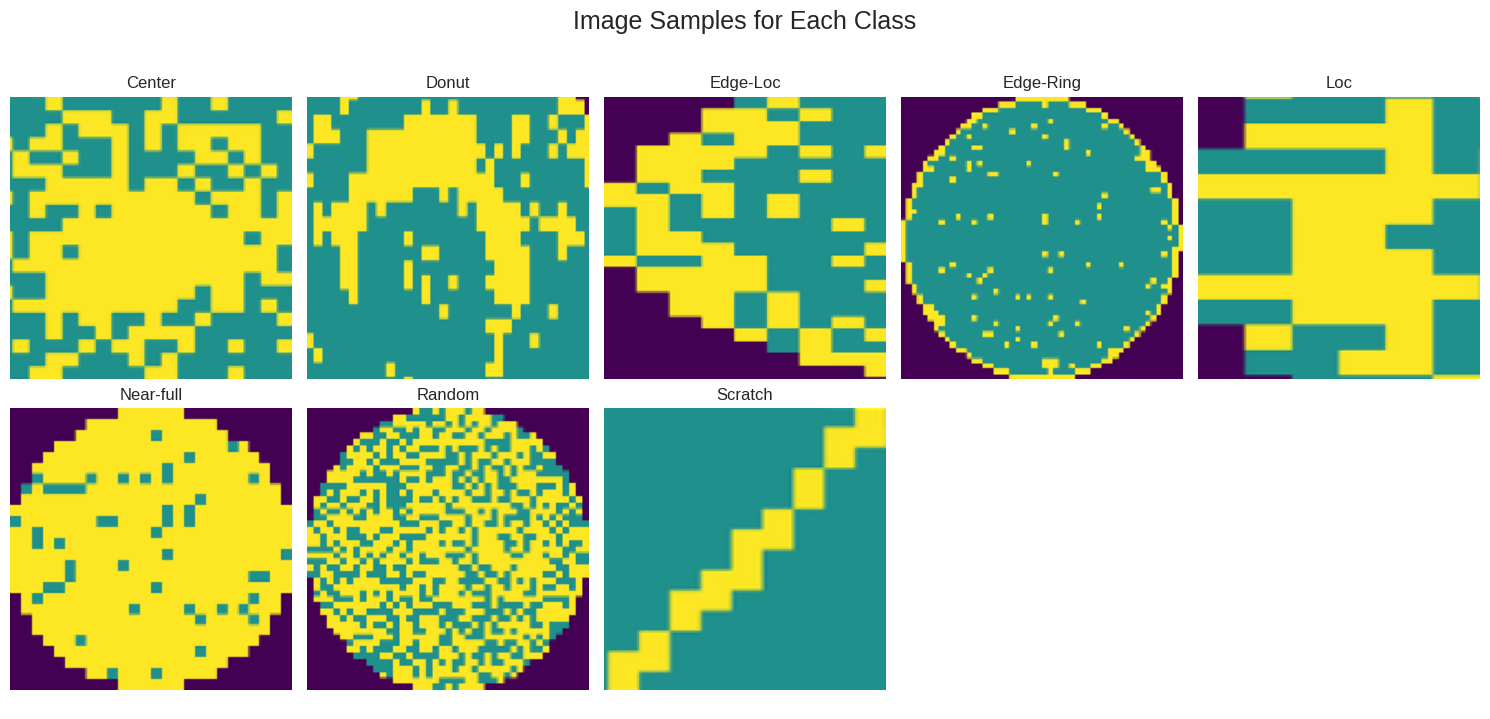

In [7]:
# 클래스별 데이터 개수 출력
print("\n 클래스별 데이터 개수")
class_counts = pd.Series(y_labels_str).value_counts()
print(class_counts)


# 각 클래스별로 하나의 이미지를 선택하여 출력
unique_classes = encoder.classes_
num_classes = len(unique_classes)

# 격자 크기 계산
cols = 5
rows = math.ceil(num_classes / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3.5))
axes = axes.flatten() # 2D 배열을 1D로 변환

for i, class_name in enumerate(unique_classes):

  # 해당 클래스의 첫 이미지 선정
  idx = np.where(y_labels_str == class_name)[0][0]
  sample_image = X_images[idx]

  # 격자로 이미지 출력
  ax = axes[i]
  ax.imshow(sample_image)
  ax.set_title(class_name, fontsize=12)
  ax.axis('off') # 축 정보를 숨겨 깔끔하게 표시

# 빈 공간 제거
for j in range(i + 1, len(axes)):
  axes[j].axis('off')


plt.suptitle('이미지 샘플', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

In [8]:
# 모델 학습 결과 시각화 함수
def plot_training_history(history, model_name):

  # 정확도 그래프
  plt.figure(figsize=(14, 5))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title(f'{model_name} - Accuracy', fontsize=14)
  plt.xlabel('Epoch', fontsize=12)
  plt.ylabel('Accuracy', fontsize=12)
  plt.legend()
  plt.grid(True)

  # 손실 그래프
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title(f'{model_name} - Loss', fontsize=14)
  plt.xlabel('Epoch', fontsize=12)
  plt.ylabel('Loss', fontsize=12)
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

# 혼동 행렬 시각화 함수
def plot_confusion_matrix(y_true, y_pred_probs, class_names):

    # 확률을 최종 클래스 예측(인덱스)으로 변환
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    # 원-핫 인코딩된 실제 라벨을 클래스 인덱스로 변환
    y_true_classes = np.argmax(y_true, axis=1)

    # 혼동 행렬 계산
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    # 혼동 행렬 시각화
    plt.figure(figsize=(8, 7))

    sns.heatmap(
      cm,
      annot=True, # 각 셀에 숫자 표시
      fmt='d', # 정수 형태로 포맷팅
      cmap='Blues',
      xticklabels=class_names,
      yticklabels=class_names
    )

    plt.xlabel('Predicted Class', fontsize=12)
    plt.ylabel('Actual Class', fontsize=12)
    plt.title('Confusion Matrix', fontsize=15)
    plt.show()


## **1. Multi-Input Early Fusion Multi-Layer Perception**

In [19]:
# --- 모델 구성 ---

# 1. 입력층 정의 (이미지와 좌표, 두 종류의 입력을 받음)
image_input = Input(shape=(128, 128, 3), name='image_input')
coords_input = Input(shape=(4,), name='coords_input')

# 2. 브랜치 모델링
# 2-1. 이미지 처리 브랜
image_flatten = Flatten()(image_input)
image_features = Dense(128, activation='relu')(image_flatten)

# 2-2. 좌표 처리층
coords_features = Dense(16, activation='relu')(coords_input)

# 3. 두 브랜치 결합
combined = concatenate([image_features, coords_features])

# 4. 최종 분류층
x = Dense(64, activation='relu')(combined)

# 출력층
output = Dense(num_classes, activation='softmax')(x)  # num_classes: 최종 분류할 클래스의 개수

# 5. 최종 모델 생성
model_simple_nn = Model(inputs=[image_input, coords_input], outputs=output)

# 모델 구조 확인
model_simple_nn.summary()

# --- 모델 컴파일 ---
model_simple_nn.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # 다중 클래스 분류용 손실 함수
    metrics=['accuracy']
)

# --- 모델 훈련 ---

# 조기 종료(Early Stopping) 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 훈련 실행
history_simple_nn = model_simple_nn.fit(
    [X_img_train, X_coords_train], y_train, # 훈련 데이터를 리스트로 전달
    epochs=50,
    batch_size=32,
    validation_data=([X_img_test, X_coords_test], y_test), # 검증 데이터도 리스트로 전달
    callbacks=[early_stopping]
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 49152)     │          0 │ image_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ coords_input        │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 128)       │  6,291,584 │ flatten_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 16)        │         80 │ coords_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 144)       │          0 │ dense_21[0][0],   │
│ (Concatenate)       │                   │            │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 64)        │      9,280 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 8)         │        520 │ dense_23[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,301,464 (24.04 MB)

 Trainable params: 6,301,464 (24.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4891 - loss: 4.9699 - val_accuracy: 0.6887 - val_loss: 1.0212
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7477 - loss: 0.8017 - val_accuracy: 0.7976 - val_loss: 0.6175
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7912 - loss: 0.6315 - val_accuracy: 0.7884 - val_loss: 0.8126
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8129 - loss: 0.5989 - val_accuracy: 0.7976 - val_loss: 0.6565
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8074 - loss: 0.6045 - val_accuracy: 0.5129 - val_loss: 1.5780
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7691 - loss: 0.7690 - val_accuracy: 0.7846 - val_loss: 0.6144
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8485 - loss: 0.3800 - val_accuracy: 0.7473 - val_loss: 0.8138
Epoch 8/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8275 - loss: 0.4874 - val_accuracy: 

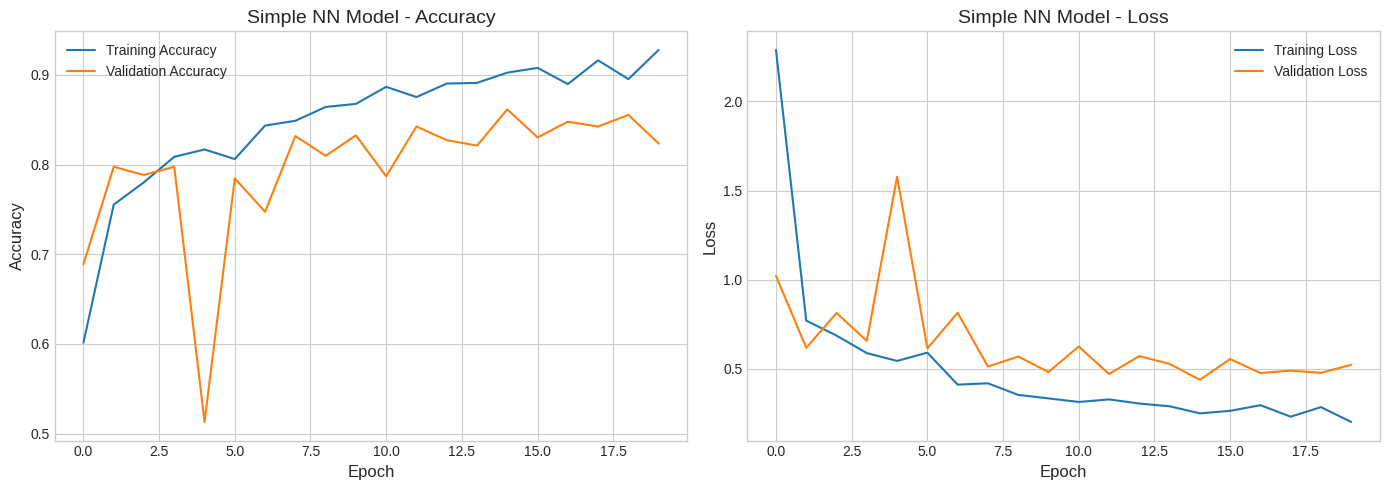

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


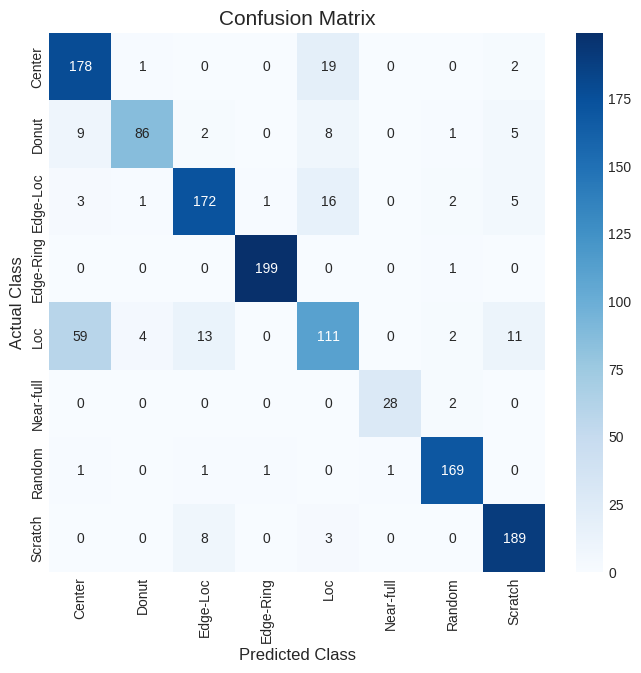

In [20]:
# 훈련 모델 성능 시각화
plot_training_history(history_simple_nn, "Simple NN Model")

# 테스트 데이터로 예측 수행
y_pred_probabilities = model_simple_nn.predict([X_img_test, X_coords_test])

# 혼동 행렬 시각화
plot_confusion_matrix(y_test, y_pred_probabilities, encoder.classes_)

## **2.**